In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import camelot
import PyPDF2
import os

In [2]:
def contains(of:str, contains:list) -> bool:
    for cont in contains:
        if cont in of:
            return True
    
    return False

In [3]:
def classify_file(file_path):
    try:
        extension = os.path.splitext(file_path)[1]

        match extension:
            case ".pdf":
                with open(file_path, "rb") as file:
                    reader = PyPDF2.PdfReader(file)
                    content = reader.pages[0].extract_text()
            case ".xlsx":
                content = pd.read_excel(file_path).to_string()
            case ".xlsb":
                content = pd.read_excel(file_path, engine='pyxlsb').to_string()
            case _:
                return "OTHER"

        content = content.lower()
        if "wrapbook" in content:
            return "OTHER"
        elif "purchase order" in content:
            return "PO"
        elif "payroll" in content:
            return "PR"
        elif "hot budget" in content:
            return "CS"
        else:
            return "OTHER"
    except:
        print("classification error at ", file_path)
        return "OTHER"

In [4]:
def get_dept_from_line(ln:int) -> str:
    try:
        ln = int(ln)
    except ValueError:
        return ln

    if ln in range(51):
        return "PRE-PRODUCTION | WRAP LABOR"
    elif ln in range(51, 101):
        return "SHOOTING LABOR"
    elif ln in range(101, 114):
        return "PRE-PRODUCTION | WRAP EXPENSES"
    elif ln in range(114, 140):
        return "LOCATION AND TRAVEL"
    elif ln in range(140,151):
        return "MAKEUP, WARDROBE, AND ANIMALS"
    elif ln in range(151, 168):
        return "STUDIO | STAGE RENTAL / EXPENSES"
    elif ln in range(168,181):
        return "ART DEPARTMENT LABOR"
    elif ln in range(181, 193):
        return "ART DEPARTMENT EXPENSES"
    elif ln in range(193, 211):
        return "EQUIPMENT COSTS"
    elif ln in range(211, 217):
        return "FILMSTOCK, DEVELOP AND PRINT"
    elif ln in range(217,227):
        return "MISCELLANEOUS"
    elif ln in range(227, 234):
        return "DIRECTOR | CREATIVE FEES"
    elif ln in range(234, 271):
        return "TALENT LABOR"
    elif ln in range(271, 277):
        return "TALENT EXPENSES"
    elif ln in range(277, 282):
        return "POST PRODUCTION LABOR"
    elif ln in range(282, 330):
        return "EDITORIAL | FINISHING | POST PRODUCTION"
    else:
        return "OTHER"

In [5]:
def read_cost_summary(_df) -> pd.DataFrame:
    _df = _df.copy()

    x = _df.loc[0]
    x[1] = "drop"

    _df.columns = x
    _df.drop(columns=["drop"], inplace=True)
    _df = _df.loc[1:]
    _df.drop(12, inplace=True)

    _df = _df.replace([r"CS\d+\b ", r".*\n", "\)", ","], "", regex=True).replace("\(", "-", regex=True)

    _df.iloc[:, 1:] = _df.iloc[:, 1:].replace("", np.nan).astype(float)

    # _df = _df.dropna(thresh=3).fillna(0.0) # if drop empty rows

    return _df.reset_index(drop=True)

In [6]:
PR_COLS = ['LINE', 'PAYEE', 'PO', 'F1', 'F2', 'DAYS', 'RATE', 'BASE', '1.5', '2', '3', 'TAXABLE', 'NON-TAX', 'TOTAL ST', 'TOTAL OT', 'ACTUAL', 'FRINGE 1', 'FRINGE 2', 'LINE DESCRIPTION']

def read_pdf_payroll(path) -> pd.DataFrame:
    _df = camelot.read_pdf(path)._tables[0].df.copy()
    
    _df.columns = PR_COLS
    _df = _df.iloc[1:].reset_index(drop=True).replace("", np.nan).dropna(how="all")

    _df.LINE.fillna(_df.PAYEE, inplace=True)
    _df[['LINE', 'PAYEE']] = _df.LINE.str.split(" ", n=1, expand=True)

    _df = _df.replace(["\)", ","], "", regex=True).replace("\(", "-", regex=True)
    _df.ACTUAL = _df.ACTUAL.astype(float)

    return _df

In [7]:

PO_COLS = ["LINE", "PAYEE", "PO", "DATE", "PAYID", "ACTUAL", "LINE DESCRIPTION"]

def read_pdf_purchase_order(path) -> pd.DataFrame:
    _df = camelot.read_pdf(path)._tables[0].df.copy()
    
    _df.columns = PO_COLS
    _df = _df.iloc[1:].reset_index(drop=True).replace("", np.nan).dropna(how="all")

    _df.LINE.fillna(_df.PAYEE, inplace=True)
    _df[['LINE', 'PAYEE']] = _df.LINE.str.split(" ", n=1, expand=True)

    _df.ACTUAL.fillna(_df["LINE DESCRIPTION"], inplace=True)
    _df[['ACTUAL', 'LINE DESCRIPTION']] = _df.ACTUAL.str.split(" ", n=1, expand=True)

    _df = _df.replace(["\)", ","], "", regex=True).replace("\(", "-", regex=True)
    _df.ACTUAL = _df.ACTUAL.astype(float)

    return _df

In [8]:
def read_sheet(path, extension) -> pd.DataFrame:
    match extension:
        case ".xlsx":
            _df = pd.read_excel(path, header=4)
        case ".xlsb":
            _df = pd.read_excel(path, engine='pyxlsb', header=4)
    
    _df = _df.replace(["\)", ","], "", regex=True).replace("\(", "-", regex=True)
    _df.ACTUAL = _df.ACTUAL.astype(float)
    if "RATE" in _df.columns:
        print("hi")
        _df.RATE = _df.RATE.astype(float)
    
    return _df

In [9]:
def read_payroll(path) -> pd.DataFrame:
    extension = os.path.splitext(path)[1]

    if extension == ".pdf":
        return read_pdf_payroll(path)
    else:
        return read_sheet(path, extension)


def read_purchase_order(path) -> pd.DataFrame:
    extension = os.path.splitext(path)[1]

    if extension == ".pdf":
        return read_pdf_purchase_order(path)
    else:
        return read_sheet(path, extension)

In [10]:
start_dir = "data/JOB_ACTUALS"

payroll_dfs = []


for directory in os.listdir(start_dir):
    dir_path = os.path.join(start_dir, directory)
    good = True
    dir_files = {}

    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file)
            _type = classify_file(file_path)
            if not _type in dir_files:
                dir_files[_type] = []
            
            dir_files[_type].append(file_path)
    
    for _type in ["PO", "PR", "CS"]:
        if not _type in dir_files:
            good = False
    
    if dir_files.get("PR"):
        for pr_path in dir_files.get("PR"):
            df = read_payroll(pr_path)
            df["PROJECT_NAME"] = directory
            payroll_dfs.append(df)

    
    if good:
        print(directory)
        
    


hi
22003_EA
22004_USPS
hi
22007_JOEL
hi
22005_CORCEPT


In [11]:
pr_combined = pd.concat(payroll_dfs)
pr_combined.RATE = pr_combined.RATE.astype(float)
pr_combined.DAYS = pr_combined.DAYS.astype(float)

pr_combined["EST"] = pr_combined.RATE * pr_combined.DAYS
pr_combined["VARIANCE"] = pr_combined.ACTUAL - pr_combined.EST
pr_combined["VAR_PCT"] = pr_combined.VARIANCE / pr_combined.EST
pr_combined["SECTION"] = pr_combined.LINE.apply(get_dept_from_line)


In [12]:
pr_combined.PROJECT_NAME.unique()

array(['22003_EA', '22004_USPS', '22007_JOEL', '22005_CORCEPT'],
      dtype=object)

/var/folders/6g/3tz5tpjs4zj1cqs2xh_sq0m40000gn/T/ipykernel_85603/2065990332.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pr_combined.groupby(BY).mean().sort_values(FOR, ascending=True).query("%s > 0" % FOR)[FOR].plot(kind="barh", ax=ax)


Text(0.5, 0, 'Amount Over Budget ($)')

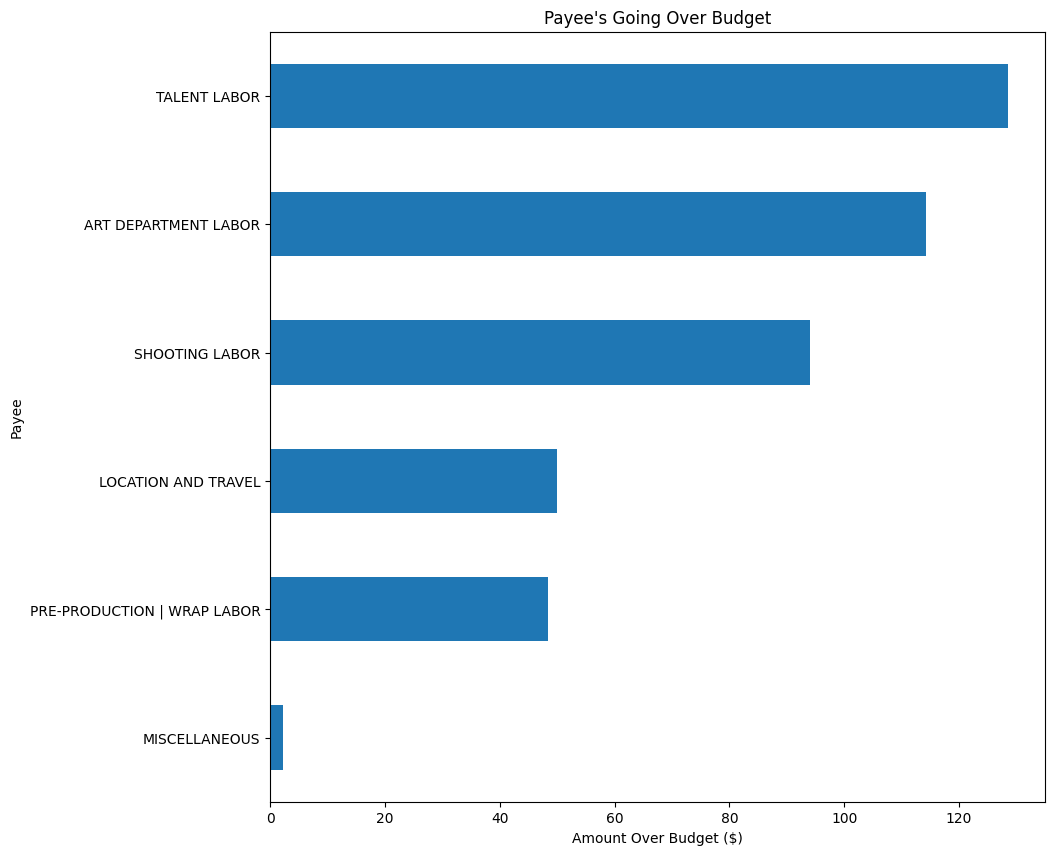

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))

BY = "SECTION"
FOR = "VARIANCE"

pr_combined.groupby(BY).mean().sort_values(FOR, ascending=True).query("%s > 0" % FOR)[FOR].plot(kind="barh", ax=ax)

ax.set_title("Payee's Going Over Budget")
ax.set_ylabel("Payee")
ax.set_xlabel("Amount Over Budget ($)")